# Fitting NorESM2 with ice mods

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from classes import CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(mods_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
files = os.listdir(case_dir)
files.sort()
files

['.ipynb_checkpoints',
 '20191122_161009_sampleparamset_wbf_1_inp_1',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
 '20200218_1726

In [6]:
origin_case = '20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1'

mainmetric = CT_SLF_Metric(case_dir)
mainmetric.add_case(origin_case) # origin point
mainmetric.add_case('20200323_135834_singleparam_cam61_arctic2_wbf_0.1_inp_0.01')
mainmetric.add_case('20200327_125556_singleparam_cam61_arctic2_wbf_0.1_inp_0.05')
#mainmetric.add_case('20200327_125556_singleparam_cam61_arctic2_wbf_0.3_inp_0.01')
mainmetric.add_case('20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_0.1')
mainmetric.add_case('20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_1.0')
mainmetric.add_case('20200402_160023_singleparam_cam61_arctic2_wbf_1.0_inp_0.1')
mainmetric.add_case('20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05')

mainmetric.set_origin(origin_case)

Trying to load concatenated file for 20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200323_135834_singleparam_cam61_arctic2_wbf_0.1_inp_0.01


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200327_125556_singleparam_cam61_arctic2_wbf_0.1_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_0.1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_1.0


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200402_160023_singleparam_cam61_arctic2_wbf_1.0_inp_0.1
Trying to load concatenated file for 20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


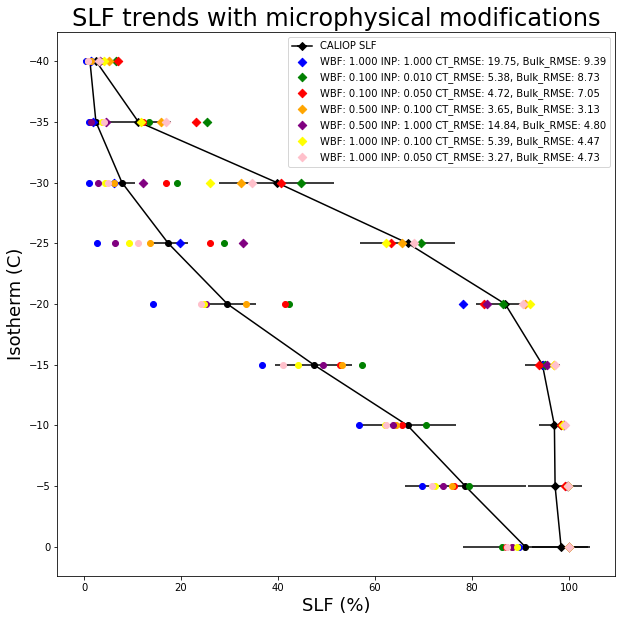

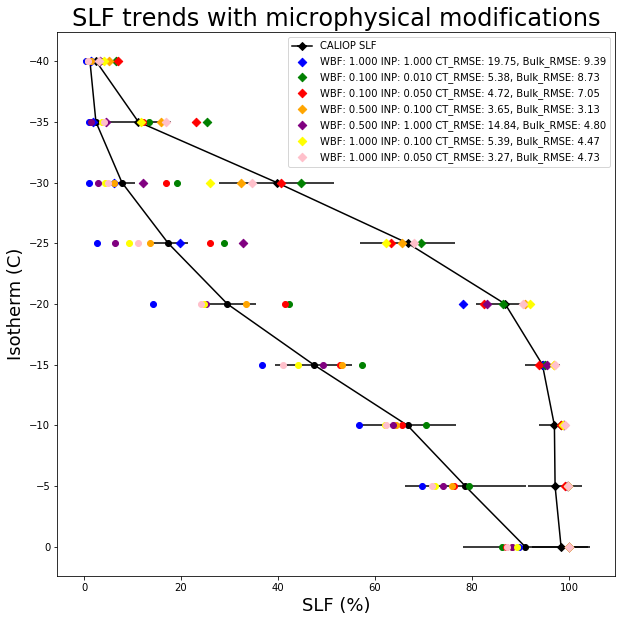

In [7]:
mainmetric.plot_isos_all()

In [4]:
origin_case = '20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1'

testmetric = CT_SLF_Metric(case_dir)
testmetric.add_case(origin_case) # origin point
testmetric.add_case('20200323_135834_singleparam_cam61_arctic2_wbf_0.1_inp_0.01')
testmetric.add_case('20200327_125556_singleparam_cam61_arctic2_wbf_0.1_inp_0.05')
testmetric.add_case('20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05')
testmetric.add_case('20200407_114050_singleparam_cam61_arctic2_wbf_0.2_inp_0.2')
testmetric.add_case('20200407_114050_singleparam_cam61_arctic2_wbf_0.2_inp_1.0')
testmetric.add_case('20200408_184035_singleparam_cam61_arctic2_wbf_0.2_inp_0.3')
testmetric.add_case('20200408_184035_singleparam_cam61_arctic2_wbf_0.2_inp_0.3')


testmetric.set_origin(origin_case)

Trying to load concatenated file for 20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200323_135834_singleparam_cam61_arctic2_wbf_0.1_inp_0.01


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200327_125556_singleparam_cam61_arctic2_wbf_0.1_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200407_114050_singleparam_cam61_arctic2_wbf_0.2_inp_0.2


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200407_114050_singleparam_cam61_arctic2_wbf_0.2_inp_1.0


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200408_184035_singleparam_cam61_arctic2_wbf_0.2_inp_0.3


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [9]:
badcase = testmetric.get_case('20200408_184035_singleparam_cam61_arctic2_wbf_0.2_inp_0.3')
goodcase = testmetric.get_case('20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05')

In [10]:
bad_da = badcase.case_da
good_da = goodcase.case_da

In [12]:
print(bad_da['time'])
print(good_da['time'])

<xarray.DataArray 'time' (time: 12)>
array(['2009-10-01T00:00:00.000000000', '2009-11-01T00:00:00.000000000',
       '2009-12-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2010-02-01T00:00:00.000000000', '2010-03-01T00:00:00.000000000',
       '2010-04-01T00:00:00.000000000', '2010-05-01T00:00:00.000000000',
       '2010-06-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000',
       '2010-08-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-10-01 2009-11-01 ... 2010-09-01
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' (time: 12)>
array(['2009-10-01T00:00:00.000000000', '2009-11-01T00:00:00.000000000',
       '2009-12-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2010-02-01T00:00:00.000000000', '2010-03-01T00:00:00.000000000',
       '2010-04-01T00:00:00.000000000',

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


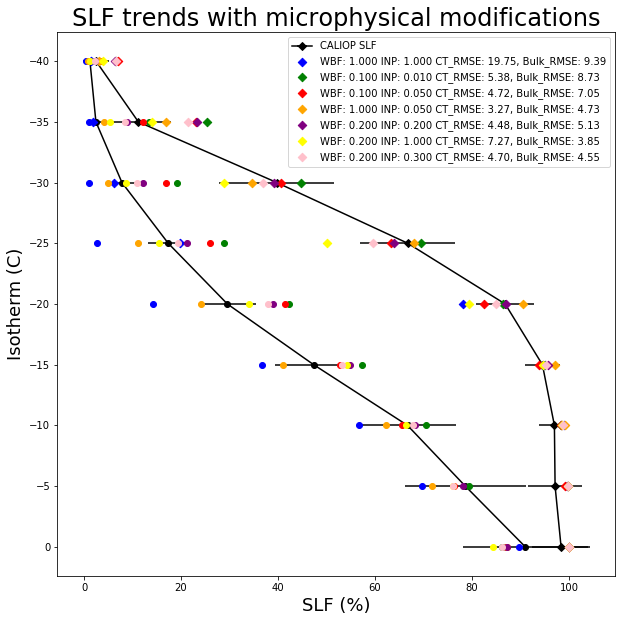

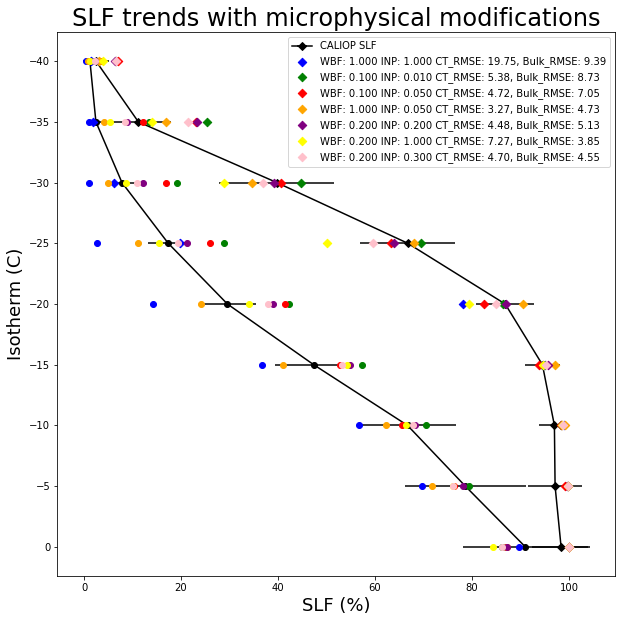

In [5]:
testmetric.plot_isos_all()

-7.7830673996041675 -10.393336664941275
6.4769404630783685 3.4912063811528555
4.346775641635598 1.4949273695262073
-3.864309140918097 1.6910276696673803
3.2971047999205263 2.167761476126698
0.4363558089088087 -2.784347376552808
2.2480534890533836 1.0313430437876532


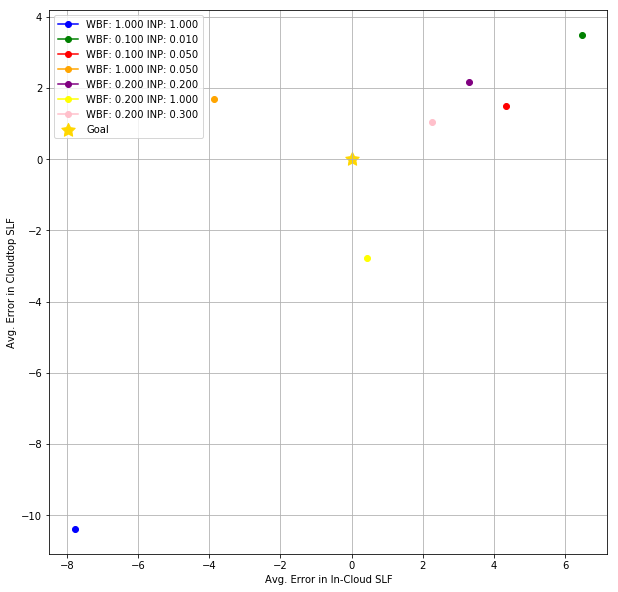

In [6]:
testmetric.dual_parameterspace()

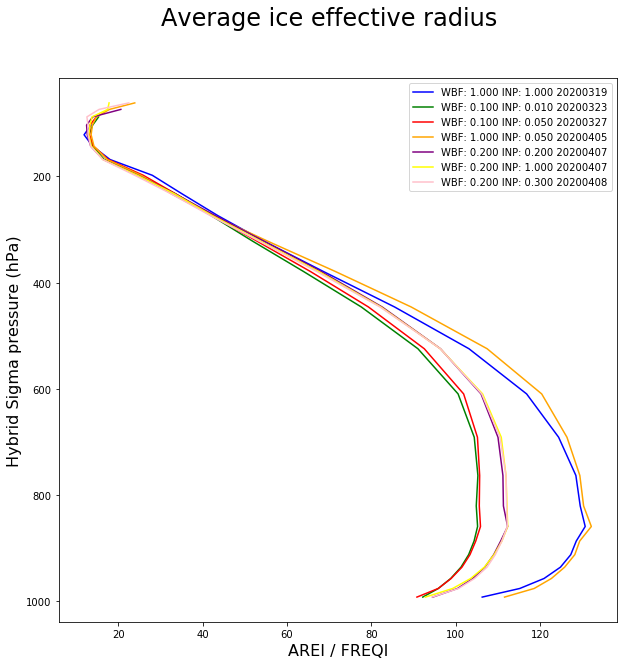

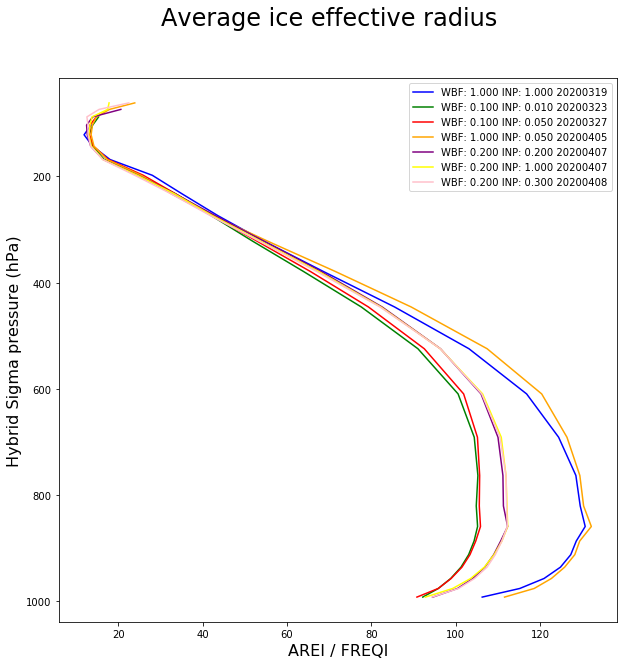

In [7]:
testmetric.plot_var_ratio('AREI','FREQI')

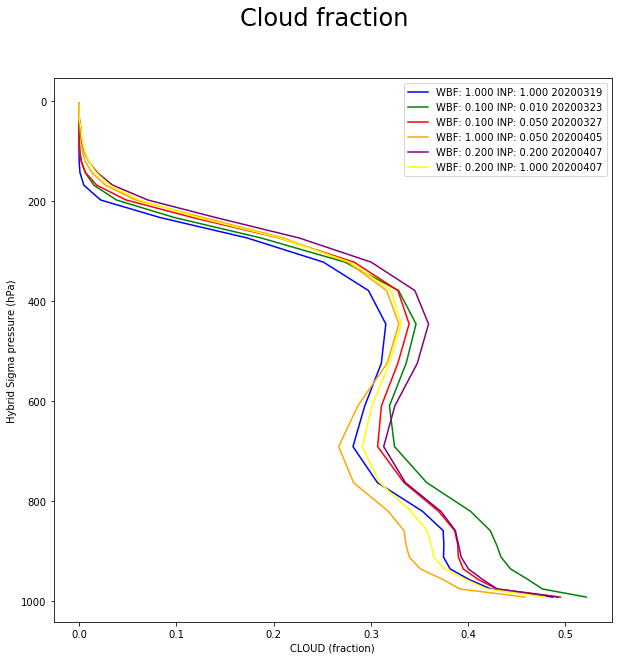

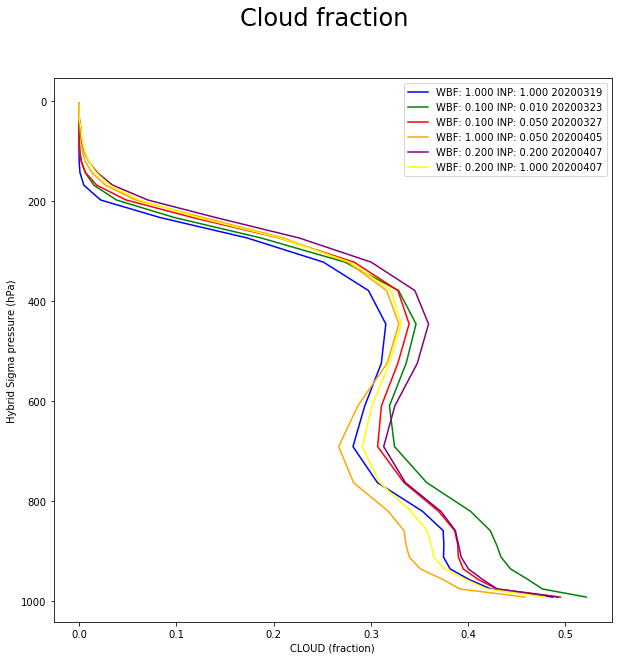

In [8]:
testmetric.plot_single_var('CLOUD')

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


-7.7830673996041675 -10.393336664941275
6.4769404630783685 3.4912063811528555
4.346775641635598 1.4949273695262073
4.679587339684023 8.214468434256624
-0.2103374384133024 1.2676664468774552
-3.364598691653228 -7.119227524213057
-3.529575353608191 -0.27972535434838897


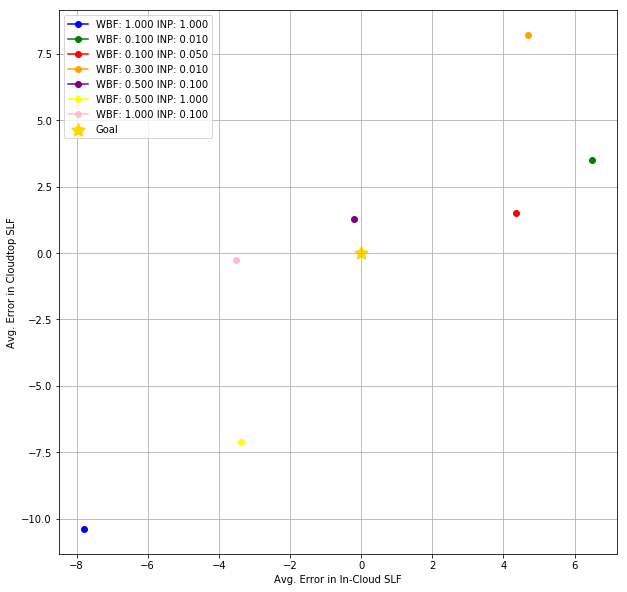

In [6]:
mainmetric.dual_parameterspace()

In [4]:
origin_case = '20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1'

bestmetric = CT_SLF_Metric(case_dir)
bestmetric.add_case(origin_case) # origin point
bestmetric.add_case('20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_0.1')
bestmetric.add_case('20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05')
bestmetric.add_case('20200501_180255_singleparam_cam61_arctic2_wbf_0.1_inp_1.0')
bestmetric.add_case('20200501_180255_singleparam_cam61_arctic2_wbf_0.2_inp_0.2')

bestmetric.set_origin(origin_case)

Trying to load concatenated file for 20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200402_160023_singleparam_cam61_arctic2_wbf_0.5_inp_0.1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200501_180255_singleparam_cam61_arctic2_wbf_0.1_inp_1.0


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200501_180255_singleparam_cam61_arctic2_wbf_0.2_inp_0.2


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
case = bestmetric.get_case('20200501_180255_singleparam_cam61_arctic2_wbf_0.2_inp_0.2')
da = case.case_da
da

<xarray.Dataset>
Dimensions:             (bnds: 2, isotherms_mpc: 9, lat: 96, lev: 32, lon: 144, time: 12)
Coordinates:
  * time                (time) datetime64[ns] 2009-07-01 ... 2010-06-01
  * lat                 (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon                 (lon) float64 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lev                 (lev) float64 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * isotherms_mpc       (isotherms_mpc) float64 233.1 238.1 ... 268.1 273.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    lev_bnds            (lev, bnds) float64 ...
    isotherms_mpc_bnds  (isotherms_mpc, bnds) float64 ...
    gw                  (lat) float64 ...
    ACTNI               (time, lat, lon) float32 ...
    ACTNL               (time, lat, lon) float32 ...
    ACTREI              (time, lat, lon) float32 ...
    ACTREL              (time, lat, lon) float32 ...
    AREI                (time, lev, lat, lon) float32 ...
    AREL                (time, lev, lat, lon) float32 ...
    AWNC                (time, lev, lat, lon) float32 ...
    AWNI                (time, lev, lat, lon) float32 ...
    CLDFREE             (time, lat, lon) float32 ...
    CLDHGH              (time, lat, lon) float32 ...
    CLDICE              (time, lev, lat, lon) float32 ...
    CLDLIQ              (time, lev, lat, lon) float32 ...
    CLDLOW              (time, lat, lon) float32 ...
    CLDMED              (time, lat, lon) float32 ...
    CLDTOT              (time, lat, lon) float32 ...
    CLD_ISOTM           (time, isotherms_mpc, lat, lon) float32 ...
    CLOUD               (time, lev, lat, lon) float32 ...
    CT_CLD_ISOTM        (time, isotherms_mpc, lat, lon) float32 ...
    CT_SLFXCLD_ISOTM    (time, isotherms_mpc, lat, lon) float32 ...
    FLNT                (time, lat, lon) float32 ...
    FREQI               (time, lev, lat, lon) float32 ...
    FREQL               (time, lev, lat, lon) float32 ...
    FSNT                (time, lat, lon) float32 ...
    LWCF                (time, lat, lon) float32 ...
    NUMICE              (time, lev, lat, lon) float32 ...
    NUMLIQ              (time, lev, lat, lon) float32 ...
    PS                  (time, lat, lon) float32 ...
    SLFXCLD_ISOTM       (time, isotherms_mpc, lat, lon) float32 ...
    SWCF                (time, lat, lon) float32 ...
    T                   (time, lev, lat, lon) float32 ...
    TS                  (time, lat, lon) float32 ...
    cell_weight         (lat, lon) float64 4.746e-07 4.746e-07 ... 4.746e-07
    CT_SLF              (time, isotherms_mpc, lat, lon) float32 0.0 0.0 ... nan
    CT_SLF_ISOTM_AVG    (isotherms_mpc, lat, lon) float32 0.0 0.0 ... 0.9999592
    CT_SLF_TAVG         (isotherms_mpc, lat, lon) float32 0.0 0.0 ... 0.9999592
    SLF_ISOTM           (time, isotherms_mpc, lat, lon) float32 5.399025e-06 ... nan
Attributes:
    CDI:               Climate Data Interface version 1.9.3 (http://mpimet.mp...
    history:           Sat May 02 21:25:42 2020: cdo select,name=gw,FSNT,FLNT...
    source:            CAM
    Conventions:       CF-1.0
    case:              20200501_180255_singleparam_cam61_arctic2_wbf_0.2_inp_0.2
    logname:           jonahks
    initial_file:      /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami-...
    topography_file:   /cluster/shared/noresm/inputdata/noresm-only/inputForN...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1
    CDO:               Climate Data Operators version 1.9.3 (http://mpimet.mp...

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


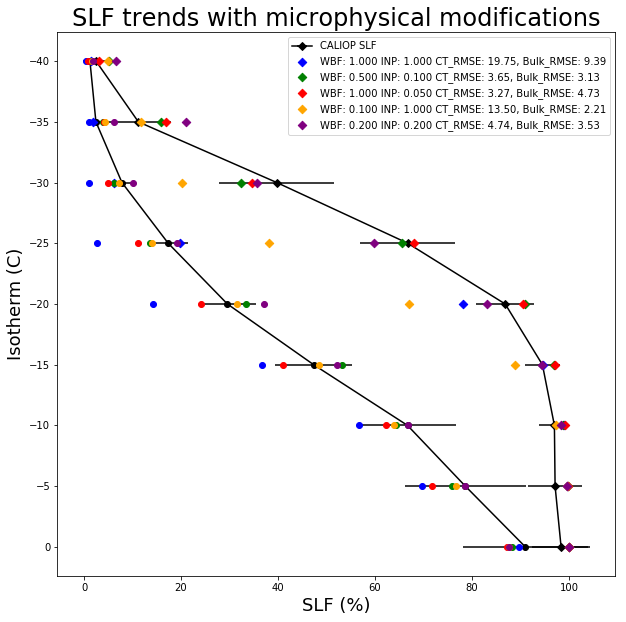

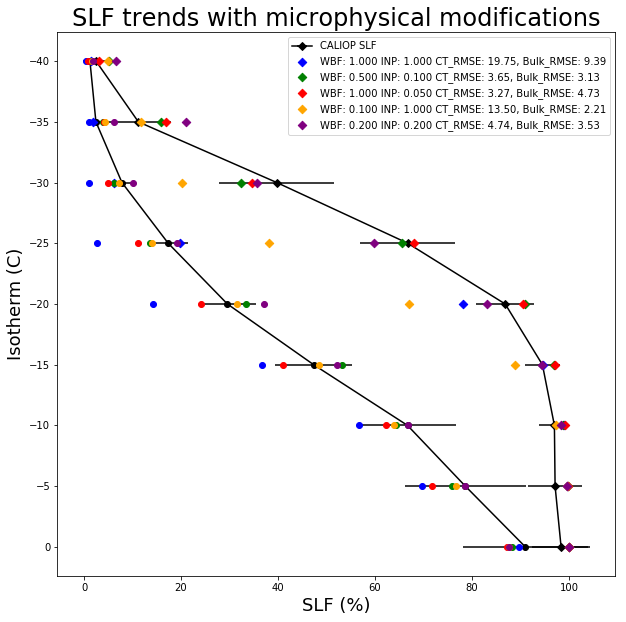

In [5]:
bestmetric.plot_isos_all()

-7.7830673996041675 -10.393336664941275
-0.2103374384133024 1.2676664468774552
-3.864309140918097 1.6910276696673803


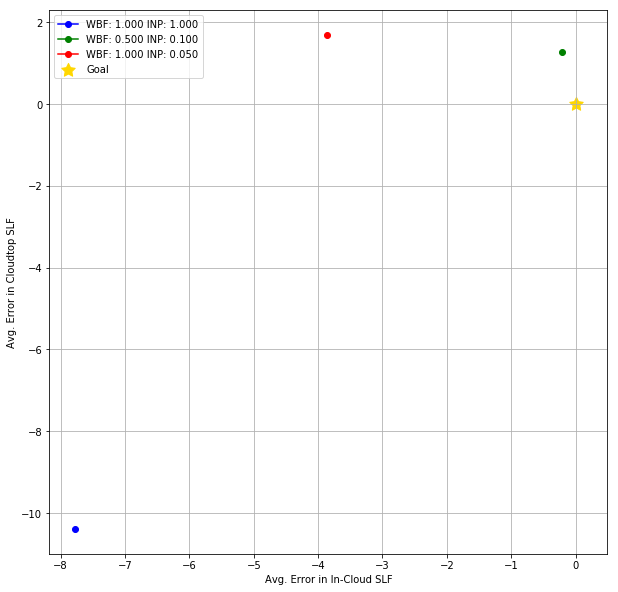

In [9]:
bestmetric.dual_parameterspace()

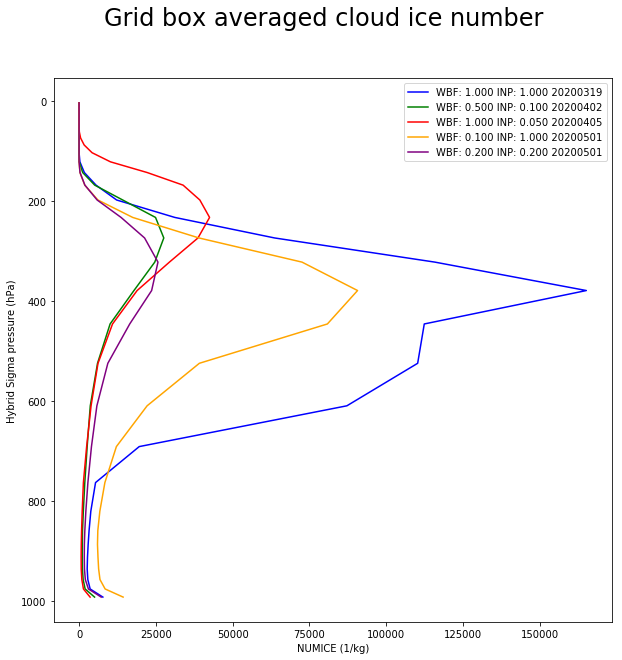

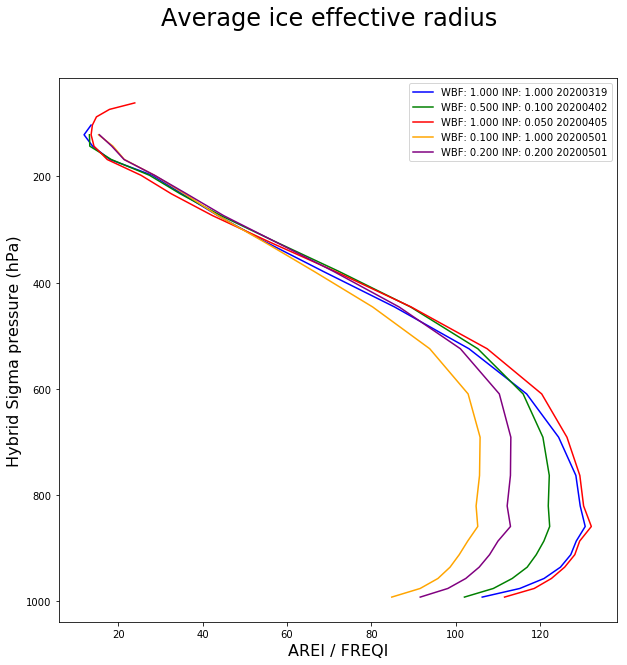

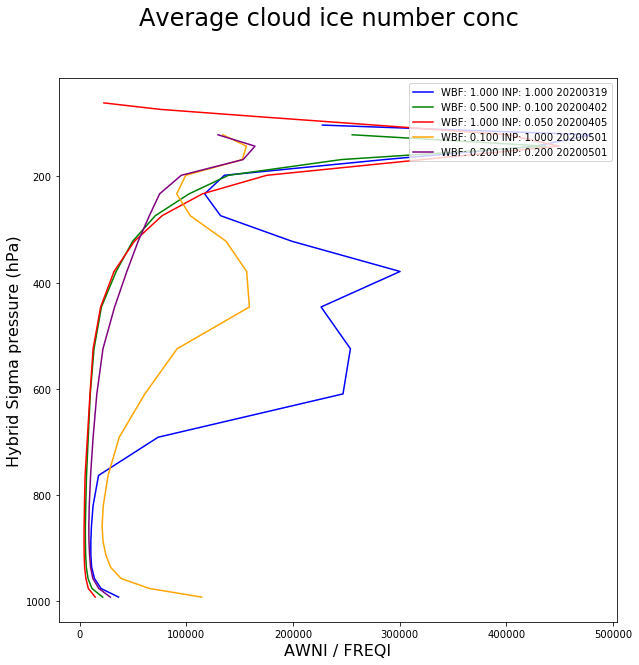

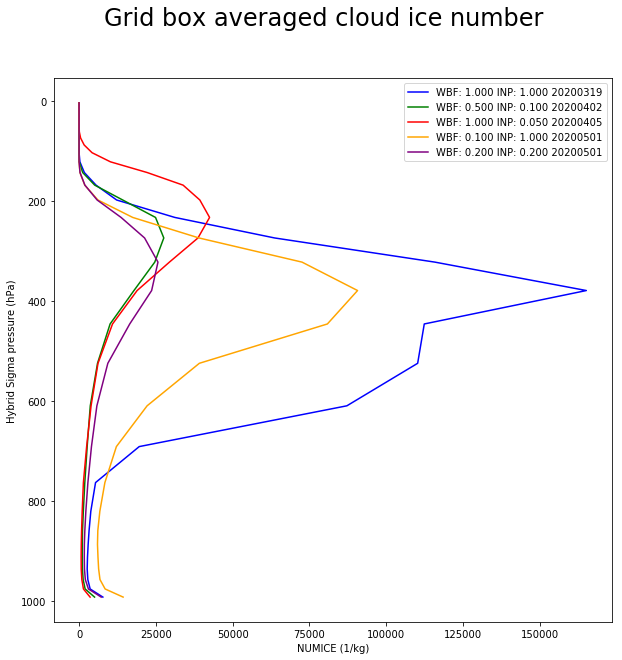

In [11]:
bestmetric.plot_var_ratio('AREI','FREQI')
bestmetric.plot_var_ratio('AWNI','FREQI')
bestmetric.plot_single_var('NUMICE')

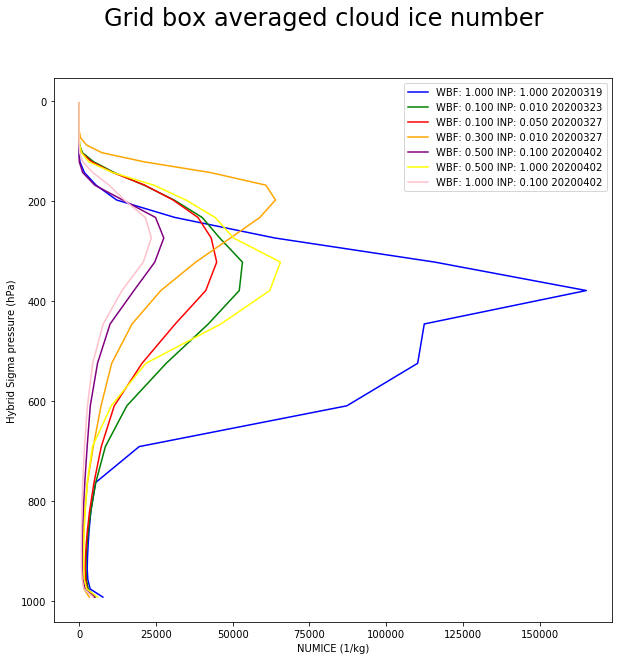

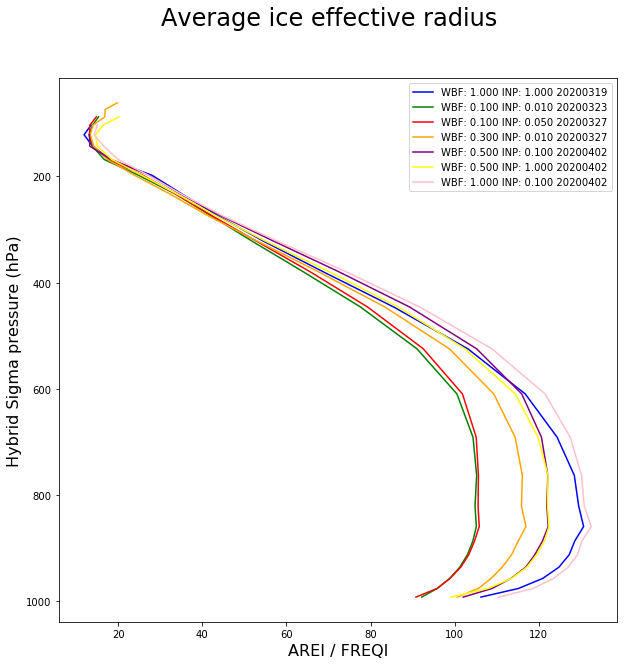

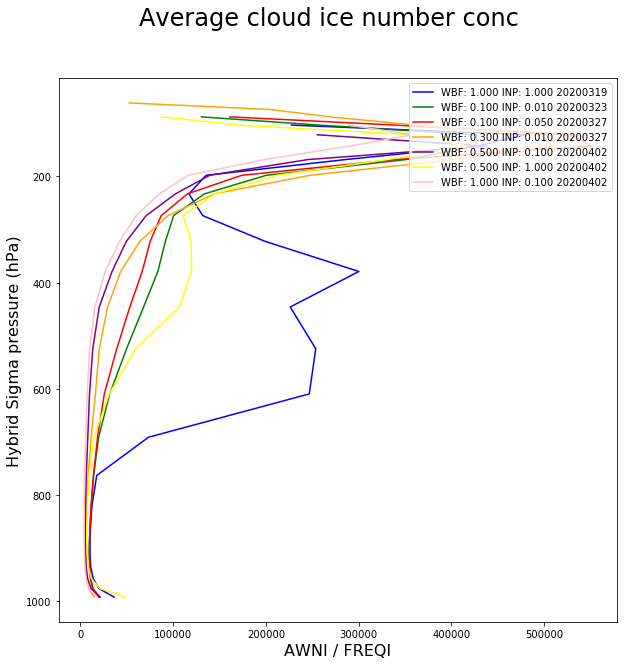

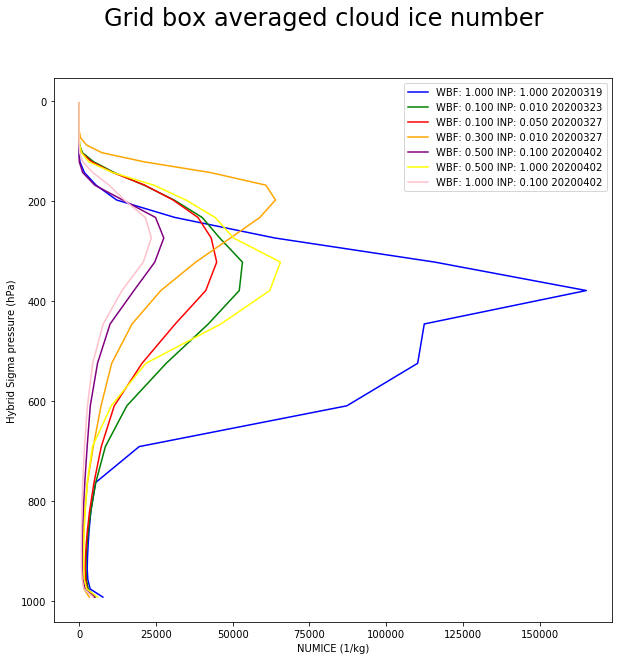

In [9]:
mainmetric.plot_var_ratio('AREI','FREQI')
mainmetric.plot_var_ratio('AWNI','FREQI')
mainmetric.plot_single_var('NUMICE')